# 심화과제: Pre-trained모델로 효율적인 NLP 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [4]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [5]:
from transformers import DistilBertTokenizer

# Load tokenizer and dataset
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

## [MY CODE]
DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 두 문장이 연속되 있는지 판단하는 문제이므로, 해당 두 문장을 서로 이어진 한문장으로 만들게 collate_fn 함수를 수정합니다. attention_mask를 추가하였는데, 기존의 padding처리 가중치를 0으로 두기 위해 다음과 같이 진행했습니다.

In [6]:
# collate_fn function
def collate_fn(batch):
    max_len = 512
    texts, labels = [], []

    for row in batch:
        sentence1 = row['premise']
        sentence2 = row['hypothesis']
        # 두개의 서로 다른 premise, hypothesis 문장을 합쳐서 하나의 문장으로 만들어줍니다.
        combined_text = f"{sentence1} [SEP] {sentence2}"
        texts.append(combined_text)
        labels.append(row['label'])  # 0: entailment, 1: neutral, 2: contradiction

    tokenized = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']
    labels = torch.LongTensor(labels)

    return input_ids, attention_mask, labels

## [MY CODE]
mnli 데이터셋을 가져오고 Custom dataset을 만듭니다.

In [11]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
import random

ds = load_dataset("glue", "mnli")
BATCH_SIZE = 16

# 하면 안되지만... 학습 시간이 너무 오래걸려서 데이터셋을 줄여서 학습합니다.
train_size = len(ds['train'])
indices = list(range(train_size))
random.shuffle(indices)
reduced_indices = indices[:train_size // 2]
reduced_train_dataset = Subset(ds['train'], reduced_indices)

train_loader = DataLoader(reduced_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(ds['validation_matched'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# label 열의 고유 값 확인
unique_labels = ds['train'].unique('label')
print(f"Unique label values: {unique_labels}")

Unique label values: [1, 0, 2]


## [MY CODE]

텍스트 분류 작업에 바로 사용하려는 경우 적합한 DistilBertForSequenceClassification를 모델로 사용했습니다.
DistilBERT의 기본 구조 위에 분류를 위한 헤드(head)가 추가된 모델이고 분류 헤드는 DistilBERT의 마지막 CLS 토큰을 입력으로 받아, 로짓(logits)을 출력합니다.
모델의 출력으로는 위에서 보시다싶이, 1, 0 ,2 로 구성되어 있기에 3을 입력합니다.

옵티마이저도 기존 Adam보다는 weight decay 기능이 추가된 AdamW를 사용했습니다.

In [17]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## [MY CODE]
분류작업이므로 정확도 함수 역시 preds = torch.argmax(outputs.logits, dim=-1)  다음과 같이 argmax 함수를 사용합니다.

In [18]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # Evaluation 모드 활성화
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for input_ids, attention_mask, labels in dataloader:
            # 데이터 로드
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # 모델 예측
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)  # logits에서 예측값 추출

            # 정확도 계산
            cnt += labels.size(0)
            acc += (preds == labels).sum().item()

    return acc / cnt

각 Epoch별 결과를 확인하기 위해 학습과 정확도 평가를 진행합니다. 기존과 틀린 부분은 찾아보니 model.zero_grad() 보다는 optimizer.zero_grad()를 사용해서 optimizer의 가중치만 초기화하여 학습을 더욱 원활하게 한다고 하여 해당 코드 역시 수정하였습니다. 아래는 pre trained 된 모델을 사용한 결과입니다.

In [1]:
import time

device = torch.device("mps")
model = model.to(device)

# Training loop
n_epochs = 10
train_loss_list = []
total_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
    start_time = time.time()  # epoch 시작 시간 기록
    model.train()
    total_loss = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Model.zero_grad()를 대신하여 사용
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch:3d} | Train Loss: {total_loss:.4f}")

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        total_loss_list.append(total_loss)
        train_loss_list.append(total_loss / len(train_loader))
        end_time = time.time()  # epoch 끝 시간 기록
        epoch_duration = end_time - start_time  # 걸린 시간 계산
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}| Duration: {epoch_duration:.2f} seconds")

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch   0 | Train Loss: 7764.4812
=========> Train acc: 0.843 | Test acc: 0.787| Duration: 2917.89 seconds
Epoch   1 | Train Loss: 5429.9649
=========> Train acc: 0.912 | Test acc: 0.799| Duration: 3044.92 seconds
Epoch   2 | Train Loss: 3841.5922
=========> Train acc: 0.955 | Test acc: 0.797| Duration: 3032.90 seconds
Epoch   3 | Train Loss: 2669.9236
=========> Train acc: 0.975 | Test acc: 0.799| Duration: 3025.37 seconds
Epoch   4 | Train Loss: 1898.5986
=========> Train acc: 0.986 | Test acc: 0.794| Duration: 3039.00 seconds
Epoch   5 | Train Loss: 1444.5731
=========> Train acc: 0.991 | Test acc: 0.800| Duration: 3118.63 seconds
Epoch   6 | Train Loss: 1138.3612
=========> Train acc: 0.994 | Test acc: 0.790| Duration: 3095.92 seconds
Epoch   7 | Train Loss: 949.3996
=========> Train acc: 0.995 | Test acc: 0.790| Duration: 3085.80 seconds
Epoch   8 | Train Loss: 822.7333
=========> Train acc: 0.996 | Test acc: 0.790| Duration: 3095.89 seconds
Epoch   9 | Train Loss: 716.9960
======

## [MY CODE]
위의 코드에서 pre trained 되 모델만 non pre trainded 된 모델로 바꾸고 역시 학습을 진행합니다. 

In [20]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=3)
model = DistilBertForSequenceClassification(config)

model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


역시 non pre trained 모델 역시 epoch를 돌려 결과를 확인합니다.

In [ ]:
# Training loop
n_epochs = 10
train_loss_list = []
total_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
    start_time = time.time()  # epoch 시작 시간 기록
    model.train()
    total_loss = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch:3d} | Train Loss: {total_loss:.4f}")

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        total_loss_list.append(total_loss)
        train_loss_list.append(total_loss / len(train_loader))
        end_time = time.time()  # epoch 끝 시간 기록
        epoch_duration = end_time - start_time  # 걸린 시간 계산
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}| Duration: {epoch_duration:.2f} seconds")

## [LOG]
Epoch   0 | Train Loss: 12494.1123<br/>
=========> Train acc: 0.527 | Test acc: 0.518| Duration: 2019.40 seconds<br/>
Epoch   1 | Train Loss: 11488.2467<br/>
=========> Train acc: 0.582 | Test acc: 0.540| Duration: 2023.26 seconds<br/>
Epoch   2 | Train Loss: 10753.2477<br/>
=========> Train acc: 0.637 | Test acc: 0.567| Duration: 2023.44 seconds<br/>
Epoch   3 | Train Loss: 10095.8543<br/>
=========> Train acc: 0.680 | Test acc: 0.594| Duration: 2024.59 seconds<br/>
Epoch   4 | Train Loss: 9365.8667<br/>
=========> Train acc: 0.725 | Test acc: 0.585| Duration: 2024.88 seconds<br/>
Epoch   5 | Train Loss: 8577.0649<br/>
=========> Train acc: 0.762 | Test acc: 0.584| Duration: 2018.12 seconds<br/>
Epoch   6 | Train Loss: 7832.2462<br/>
=========> Train acc: 0.802 | Test acc: 0.597| Duration: 2025.87 seconds<br/>
Epoch   7 | Train Loss: 7101.2893<br/>
=========> Train acc: 0.831 | Test acc: 0.603| Duration: 2021.98 seconds<br/>
Epoch   8 | Train Loss: 6400.9827<br/>
=========> Train acc: 0.851 | Test acc: 0.604| Duration: 2024.56 seconds<br/>
Epoch   9 | Train Loss: 5700.2349<br/>
=========> Train acc: 0.873 | Test acc: 0.612| Duration: 2022.08 seconds<br/>

## [MY CODE] 
위의 pre trained 모델과 non pre trained 모델의 바교값을 확인합니다.

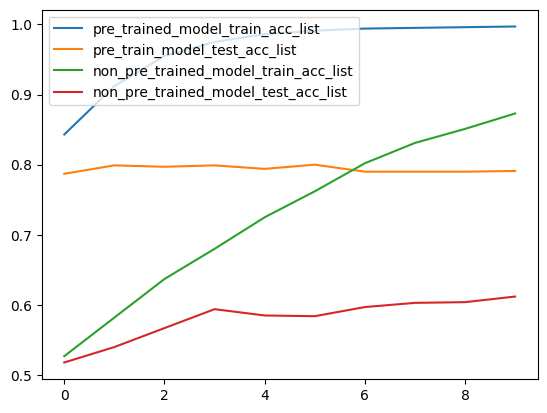

In [39]:
import matplotlib.pyplot as plt
import numpy as np

pre_train_train_acc_list = [0.843, 0.912, 0.955, 0.975, 0.986, 0.991, 0.994, 0.995, 0.996, 0.997]
pre_train_test_acc_list = [0.787, 0.799, 0.797, 0.799, 0.794, 0.800, 0.790, 0.790, 0.790, 0.791]

non_pre_train_train_acc_list = [0.527, 0.582, 0.637, 0.680, 0.725, 0.762, 0.802, 0.831, 0.851, 0.873]
non_pre_train_test_acc_list = [0.518, 0.540, 0.567, 0.594, 0.585, 0.584, 0.597, 0.603, 0.604, 0.612]

def plot_acc(pre_train_train_acc_list, pre_train_test_acc_list,non_pre_train_train_acc_list, non_pre_train_test_acc_list):
    x = np.arange(len(pre_train_train_acc_list))

    plt.plot(x, pre_train_train_acc_list, label="pre_trained_model_train_acc_list")
    plt.plot(x, pre_train_test_acc_list, label="pre_train_model_test_acc_list")
    plt.plot(x, non_pre_train_train_acc_list, label="non_pre_trained_model_train_acc_list")
    plt.plot(x, non_pre_train_test_acc_list, label="non_pre_trained_model_test_acc_list")    
    plt.legend()
    plt.show()

plot_acc(pre_train_train_acc_list, pre_train_test_acc_list, non_pre_train_train_acc_list, non_pre_train_test_acc_list)